# TCLAB Test PID en boucle fermée

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from math import exp

import package_LAB
from package_LAB import LeadLag_RT, PID_RT, Margin, IMC_Tuning
import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

from importlib import reload
package_LAB = reload(package_LAB)

import tclab
import time
from datetime import datetime
import os

## Scenario

In [62]:
Scenario = "Response to DV : FF and controller in automatic mode"

if(Scenario == "Test"):
    TSim = 25

    SPPath =  {0:25, TSim:25}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:20, 10:25, TSim:25}
    ManFF = True
    
    DVState = True
    FFShown = True
    MVManShown = True
    
    NumRTsteps = TSim

if(Scenario == "Closed-loop response to a setpoint change SP"):
    TSim = 1000

    SPPath =  {0:50, TSim:50}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:0, TSim:0}
    ManFF = True
    
    DVState = True
    FFShown = False
    MVManShown = False
    
    NumRTsteps = TSim

if(Scenario == "Response to DV : No FF and controller in manual mode"):
    TSim = 2500

    MVManPath = {0:50, 750:75, 1400:65, TSim:65}
    SPPath = MVManPath
    ManPath = {0:True, TSim:True}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = True
    
    DVState = True
    FFShown = False
    MVManShown = False
    
    NumRTsteps = TSim
    
if(Scenario == "Response to DV : FF and controller in manual mode"):
    TSim = 2500

    MVManPath = {0:50, 750:75, 1400:65, TSim:65}
    SPPath = MVManPath
    ManPath = {0:True, TSim:True}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = False
    
    DVState = True
    FFShown = True
    MVManShown = False
    
    NumRTsteps = TSim
    
if(Scenario == "Response to DV : No FF and controller in automatic mode"):
    TSim = 2500

    SPPath = {0:50, 750:75, 1400:65, TSim:65}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = True
    
    DVState = True
    FFShown = False
    MVManShown = False
    
    NumRTsteps = TSim
    
if(Scenario == "Response to DV : FF and controller in automatic mode"):
    TSim = 2500

    SPPath = {0:50, 750:75, 1400:65, TSim:65}
    MVManPath = SPPath
    ManPath = {0:False, TSim:False}
    DVPath = {0:50, 2100:60, TSim:60}
    ManFF = False
    
    DVState = True
    FFShown = True
    MVManShown = False
    
    NumRTsteps = TSim

## Calcul de DV0 & PV0

In [63]:
nameFile1 = 'Open_loop_experiment_on_MV_2024-03-18-09h26.txt'

titleName1 = nameFile1.split('.')[0]
data1 = pd.read_csv(nameFile1)
t1 = data1['t'].values - data1['t'].values[0]

PV0 = 0
for i in range(len(t1)):
    PV0 += data1['PV'].values[i]
PV0 = PV0/len(t1)
print(PV0)


70.1002900552487


## Simulation Closed loop Parameters

In [64]:
Ts = 1
N = int(TSim/Ts) + 1

MV0 = 50
DV0 = 50
PV0 = 70

t = []
MV = [MV0]
E = []
SP = []
PV = []
PV1p = []
PV2p = []
PV1d = []
PV2d = []
DV = []
DVGoal = []
Man = []
MVMan = []
MVFF = []
MVFF_Delay = []
MV_Delayp = []
MV_Delayd = []
MVP = []
MVI = []
MVD = []


# Parameters
Kp = 0.4971
Kd = 0.3734
Kff = Kd/Kp #0.7512

alpha = 0.9
theta_p = 4.386
theta_d = 12.181
theta_ff = max(0, theta_d-theta_p)

MVMin = 0
MVMax = 100

T1d = 153.9969
T2d = 42.4662

T1p = 201.8353
T2p = 14.1389

MVFFdv = []
MVFFpv = []

T1 = T1p
T2 = T2p
gamma = 0.6

## Test Closed loop


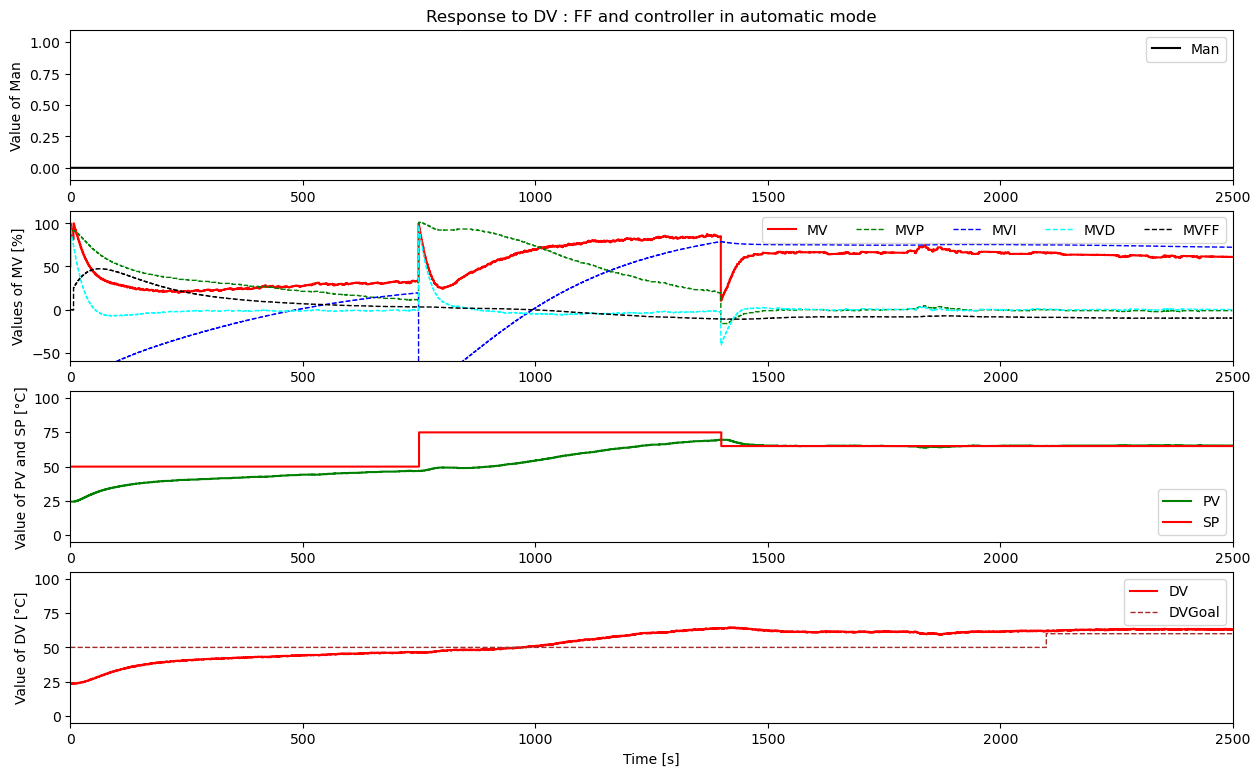

TCLab disconnected successfully.


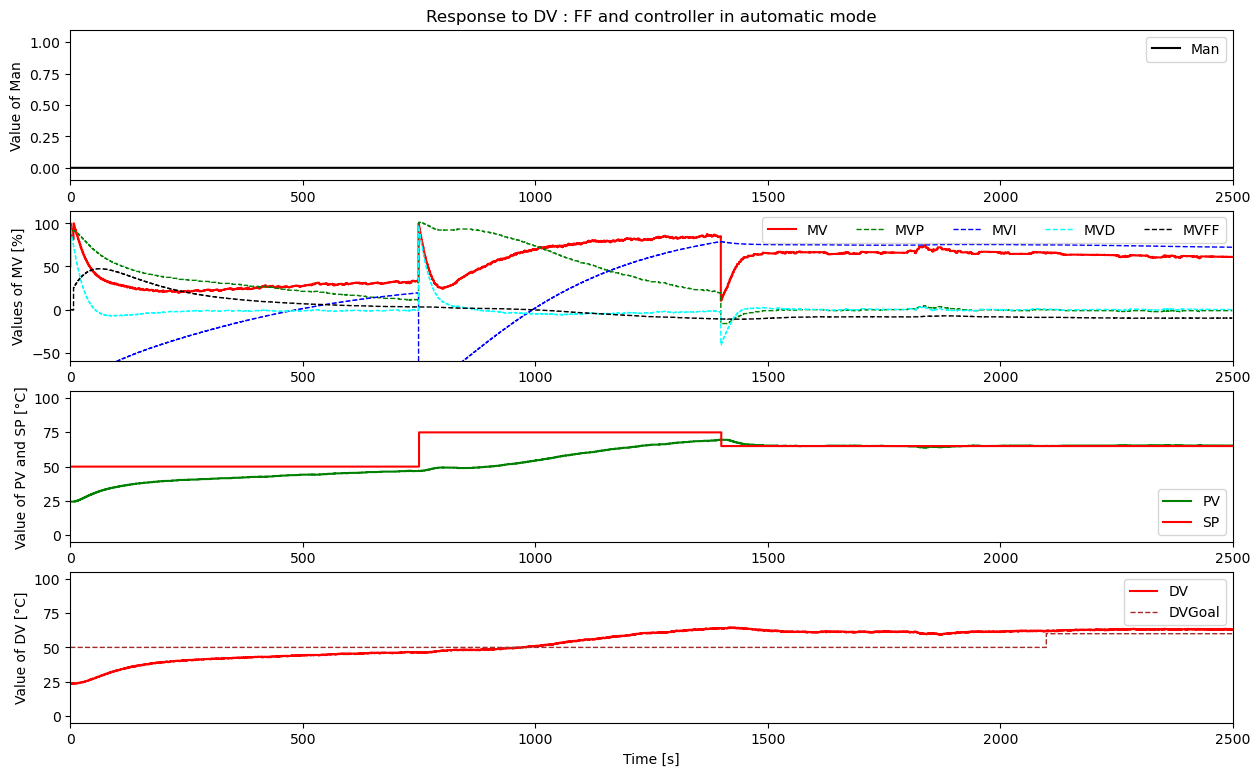

In [65]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)

fig.set_figheight(9)
fig.set_figwidth(15)

l1, = ax1.step([0, NumRTsteps],[0, 100],'black',label='Man',where='pre')
ax1.set_ylabel('Value of Man')
ax1.set_title(Scenario)
ax1.legend(loc='best')
ax1.set_xlim([0, NumRTsteps])
ax1.set_ylim([-0.1,1.1])

l2, = ax2.step([0,NumRTsteps],[0,100],'r-',label='MV',where='pre')
l3, = ax2.step([0,NumRTsteps],[0,100],'green',label='MVP',where='pre', ls = '--', linewidth = '1' )
l4, = ax2.step([0,NumRTsteps],[0,100],'blue',label='MVI',where='pre', ls = '--', linewidth = '1')
l5, = ax2.step([0,NumRTsteps],[0,100],'cyan',label='MVD',where='pre', ls = '--', linewidth = '1')
if FFShown == True:
    l6, = ax2.step([0,NumRTsteps],[0,100],'black',label='MVFF',where='pre', ls = '--', linewidth = '1')
if MVManShown == True:
    l10, = ax2.step([0,NumRTsteps],[0,100],'black',label='MVMan',where='pre', ls = '--', linewidth = '1')
ax2.set_ylabel('Values of MV [%]')
ax2.legend(ncol = 5, loc="upper right", bbox_to_anchor=(1,1))
ax2.set_xlim([0, NumRTsteps])
ax2.set_ylim([-60,115])

l7, = ax3.step([0,NumRTsteps],[0,100],'-g', label='PV',where='post')
l8, = ax3.step([0,NumRTsteps],[0,100],'-r', label='SP',where='post')
ax3.set_ylabel('Value of PV and SP [°C]')
ax3.legend(loc="lower right", bbox_to_anchor=(1,0))
ax3.set_xlim([0, NumRTsteps])

l9, = ax4.step([0,NumRTsteps],[0,100],'-r', label='DV', where='post')
l11, = ax4.step([0,NumRTsteps],[0,100],'brown', label='DVGoal', ls = '--', linewidth = '1')
ax4.set_ylabel('Value of DV [°C]')
ax4.set_xlabel('Time [s]')
ax4.legend(loc='best')
ax4.set_xlim([0, NumRTsteps])

try:
    lab = tclab.TCLab()
    
    Exp = True
    
    
    i = 0
    [Kc, Ti, Td] = IMC_Tuning(T1, T2, T1p, gamma, Kp, "B")
    
    while Exp:
        
        
        t.append(i*Ts)
        
        
        SelectPath_RT(SPPath,t,SP)
        SelectPath_RT(MVManPath,t,MVMan)
        SelectPath_RT(ManPath,t,Man)
        SelectPath_RT(DVPath,t,DVGoal)
        
                 
        lab.Q1(MV[-1])
        lab.Q2(DVGoal[-1])
        
        
        if t[-1] == 0:
            last_time = time.time()   
        
        # Wait for sampling period Ts
        now = time.time()
        delta = now - last_time
        
        time.sleep(np.max([0, Ts - delta]))
        last_time = time.time()   
        
        
          
        PV.append(lab.T1)
        DV.append(lab.T2)
        
        
        l1.set_data(t,Man)
        
        
        l2.set_data(t,MV)
        l3.set_data(t,MVP)
        l4.set_data(t,MVI)
        l5.set_data(t,MVD)
        if FFShown == True:
            l6.set_data(t,MVFF)
        
        l7.set_data(t,PV)
        l8.set_data(t,SP)
        
        if DVState == True:
            l9.set_data(t,DV)
            l11.set_data(t,DVGoal)
        
        if MVManShown == True:
            l10.set_data(t,MVMan)
        
        
        clear_output(wait=True)    

        
        
        #MVFF
        Delay_RT(DV - DV0*np.ones_like(DV),np.max([theta_d-theta_p,0]),Ts,MVFF_Delay, DV0)
        
        LeadLag_RT(MVFF_Delay, -Kff, T1p, T1d, Ts, MVFFdv)
        LeadLag_RT(MVFFdv, 1, T2p, T2d, Ts, MVFF)
    
        
        PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF)
        
        
        display(fig)     
        
        
        i = i + 1
        
        if i == NumRTsteps:
            Exp = False
            lab.close()
    
            
            
    # Save data in text file
    # ----------------------
    now = datetime.now()
    date_time = now.strftime("%Y-%m-%d-%Hh%M")
    # Conversion to array
    t = np.array(t) 
    MV = np.array(MV)
    PV = np.array(PV)
    DV = np.array(DV)        
    my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
    my_data = my_data.T
    nameFile = 'Data/RT_test_on_' + date_time + '.txt'
    if not os.path.exists('Data'):
        os.makedirs('Data')
    np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV',comments='')        
    
    
    # Save Plot
    # ---------
    if not os.path.exists('Plots'):
        os.makedirs('Plots')
    
    titleName = 'RT_test_on_' + date_time
    plt.savefig('Plots\\' + titleName + '.png',transparent=True)
    plt.savefig('Plots\\' + titleName + '.pdf',transparent=True)
    

except KeyboardInterrupt as e:
    print(e)
    
    Exp = False
    lab.close()
    
    
